In [12]:
# Libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [13]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Properties
from Property import Prop_He, Prop_kanthal
He = Prop_He()
Wall = Prop_kanthal()
# Geometry
from Geometry import ReactorGeometry, Mesh1D
geom = ReactorGeometry()
Ai = geom.Ai # [m2]
L = geom.L # [m]
# Domain
mesh = Mesh1D(geom)
N = mesh.n_nodes
dz = mesh.dz # [m]

In [14]:
# Operating conditions
V = 0.1 # [V]
P = 1.01325 # [bar]
Fv = 50.0 # [sccm]
Tin = 30.0 # [C]
Tamb = 25.0 # [C]
mdot = Fv * 1e-6 / 60.0 * He.rho(0) # [kg/s]

In [15]:
# Initial conditions
rhoi = He.rho(0) # [kg/m3]
vi = mdot / rhoi / Ai # [m/s]

# 1D Mass Balance - CasADi/IPOPT Approach

In [16]:
import casadi as ca
import numpy as np
import time

# CasADi-based 1D Mass Balance Solver
def solve_mass_balance_casadi(N, dz, mdot, rhoi, Ai):
    """
    Solve 1D steady-state mass balance using CasADi/IPOPT
    Mass balance: d(rho*v*A)/dz = 0
    """
    # Decision variables: density at each node
    rho = ca.MX.sym('rho', N)
    
    # Constraints list
    g = []
    lbg = []
    ubg = []
    
    # Boundary condition: inlet density
    g.append(rho[0] - rhoi)
    lbg.append(0)
    ubg.append(0)
    
    # Mass balance at each internal node (FDM discretization)
    # Continuity: mdot = rho * v * A = constant
    for i in range(1, N):
        # Forward difference approximation
        # (rho[i] - rho[i-1]) / dz = 0 for constant mass flow
        mass_residual = mdot - rho[i] * (mdot / (rho[i-1] * Ai)) * Ai
        g.append(mass_residual)
        lbg.append(0)
        ubg.append(0)
    
    # Objective: minimize deviation from inlet density (regularization)
    obj = ca.sumsqr(rho - rhoi)
    
    # Setup NLP
    nlp = {'x': rho, 'f': obj, 'g': ca.vertcat(*g)}
    
    # Solver options
    opts = {
        'ipopt.print_level': 0,
        'print_time': 0,
        'ipopt.max_iter': 1000,
        'ipopt.tol': 1e-8
    }
    
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)
    
    # Initial guess
    rho0 = np.ones(N) * rhoi
    
    # Solve
    start_time = time.time()
    sol = solver(x0=rho0, lbg=lbg, ubg=ubg)
    solve_time = time.time() - start_time
    
    rho_sol = np.array(sol['x']).flatten()
    
    return rho_sol, solve_time

# Solve using CasADi
print("="*60)
print("CasADi/IPOPT Solution")
print("="*60)

rho_casadi, time_casadi = solve_mass_balance_casadi(N, dz, mdot, rhoi, Ai)
v_casadi = mdot / (rho_casadi * Ai)

print(f"Solve time: {time_casadi:.4f} s")
print(f"Density range: [{rho_casadi.min():.6f}, {rho_casadi.max():.6f}] kg/m³")
print(f"Velocity range: [{v_casadi.min():.6f}, {v_casadi.max():.6f}] m/s")
print(f"Mass flow consistency: {np.std(rho_casadi * v_casadi * Ai):.2e} kg/s")

CasADi/IPOPT Solution
Solve time: 0.0013 s
Density range: [0.178484, 0.178484] kg/m³
Velocity range: [0.041937, 0.041937] m/s
Mass flow consistency: 2.65e-23 kg/s


# 1D Mass Balance - PyTorch Autograd Approach

In [17]:
# PyTorch-based 1D Mass Balance Solver
def solve_mass_balance_torch(N, dz, mdot, rhoi, Ai, lr=0.01, max_iter=10000, tol=1e-8):
    """
    Solve 1D steady-state mass balance using PyTorch Autograd
    Minimize residual of mass balance equation
    """
    # Initialize density field (requires_grad for autograd)
    # Use nn.Parameter to create a leaf tensor
    rho = nn.Parameter(torch.full((N,), rhoi, dtype=torch.float64, device=device))
    
    # Optimizer
    optimizer = torch.optim.Adam([rho], lr=lr)
    
    # History
    loss_history = []
    
    start_time = time.time()
    
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # Compute velocity from mass conservation
        v = mdot / (rho * Ai)
        
        # Mass balance residual
        # Boundary condition loss
        bc_loss = (rho[0] - rhoi)**2
        
        # Interior points: mass flux conservation
        # d(rho*v*A)/dz ≈ 0
        mass_flux = rho * v * Ai
        
        # Central difference for interior points
        flux_residual = torch.zeros(N-2, dtype=torch.float64, device=device)
        for i in range(1, N-1):
            # Central difference: (flux[i+1] - flux[i-1]) / (2*dz)
            flux_residual[i-1] = (mass_flux[i+1] - mass_flux[i-1]) / (2 * dz)
        
        # Total loss
        physics_loss = torch.mean(flux_residual**2)
        loss = bc_loss + physics_loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Record loss
        loss_val = loss.item()
        loss_history.append(loss_val)
        
        # Convergence check
        if iteration % 100 == 0:
            if iteration > 0 and abs(loss_history[-1] - loss_history[-100]) < tol:
                break
        
        # Print progress
        if iteration % 1000 == 0:
            print(f"Iter {iteration:5d}: Loss = {loss_val:.3e}")
    
    solve_time = time.time() - start_time
    
    rho_sol = rho.detach().cpu().numpy()
    
    return rho_sol, solve_time, loss_history

# Solve using PyTorch
print("\n" + "="*60)
print("PyTorch Autograd Solution")
print("="*60)

rho_torch, time_torch, loss_history = solve_mass_balance_torch(
    N, dz, mdot, rhoi, Ai, lr=0.1, max_iter=10000, tol=1e-10
)
v_torch = mdot / (rho_torch * Ai)

print(f"\nSolve time: {time_torch:.4f} s")
print(f"Final loss: {loss_history[-1]:.3e}")
print(f"Iterations: {len(loss_history)}")
print(f"Density range: [{rho_torch.min():.6f}, {rho_torch.max():.6f}] kg/m³")
print(f"Velocity range: [{v_torch.min():.6f}, {v_torch.max():.6f}] m/s")
print(f"Mass flow consistency: {np.std(rho_torch * v_torch * Ai):.2e} kg/s")


PyTorch Autograd Solution
Iter     0: Loss = 0.000e+00

Solve time: 7.5791 s
Final loss: 0.000e+00
Iterations: 101
Density range: [0.178484, 0.178484] kg/m³
Velocity range: [0.041937, 0.041937] m/s
Mass flow consistency: 2.65e-23 kg/s


# Comparison and Visualization

In [18]:
# Comparison metrics
print("\n" + "="*60)
print("Comparison Summary")
print("="*60)

# Create spatial grid
z = np.linspace(0, L, N)

# Compute differences
rho_diff = np.abs(rho_casadi - rho_torch)
v_diff = np.abs(v_casadi - v_torch)

print(f"\nSolution Time:")
print(f"  CasADi/IPOPT: {time_casadi:.4f} s")
print(f"  PyTorch:      {time_torch:.4f} s")
print(f"  Speedup:      {time_torch/time_casadi:.2f}x")

print(f"\nDensity Difference:")
print(f"  Max:  {rho_diff.max():.2e} kg/m³")
print(f"  Mean: {rho_diff.mean():.2e} kg/m³")
print(f"  RMS:  {np.sqrt(np.mean(rho_diff**2)):.2e} kg/m³")

print(f"\nVelocity Difference:")
print(f"  Max:  {v_diff.max():.2e} m/s")
print(f"  Mean: {v_diff.mean():.2e} m/s")
print(f"  RMS:  {np.sqrt(np.mean(v_diff**2)):.2e} m/s")

# Mass conservation check
mdot_casadi = rho_casadi * v_casadi * Ai
mdot_torch = rho_torch * v_torch * Ai

print(f"\nMass Flow Conservation:")
print(f"  CasADi - Std Dev: {np.std(mdot_casadi):.2e} kg/s")
print(f"  PyTorch - Std Dev: {np.std(mdot_torch):.2e} kg/s")
print(f"  Target mass flow: {mdot:.6e} kg/s")


Comparison Summary

Solution Time:
  CasADi/IPOPT: 0.0013 s
  PyTorch:      7.5791 s
  Speedup:      5745.33x

Density Difference:
  Max:  0.00e+00 kg/m³
  Mean: 0.00e+00 kg/m³
  RMS:  0.00e+00 kg/m³

Velocity Difference:
  Max:  0.00e+00 m/s
  Mean: 0.00e+00 m/s
  RMS:  0.00e+00 m/s

Mass Flow Conservation:
  CasADi - Std Dev: 2.65e-23 kg/s
  PyTorch - Std Dev: 2.65e-23 kg/s
  Target mass flow: 1.487366e-07 kg/s


/tmp/ipykernel_3707/2631055238.py:41: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_3707/2631055238.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_3707/2631055238.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


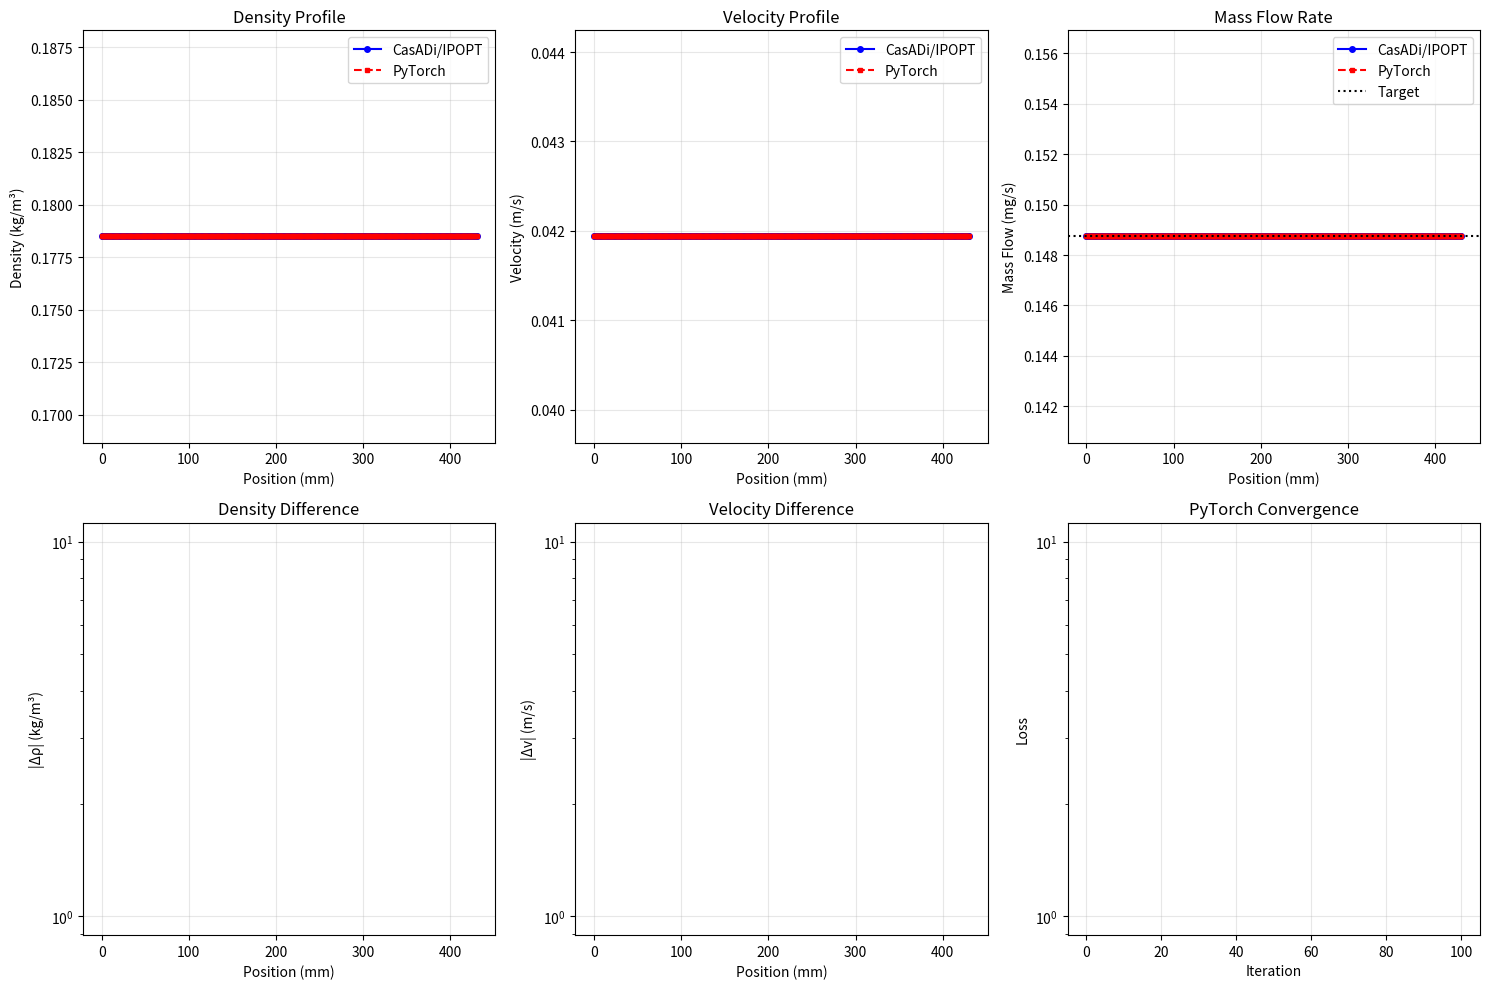

In [19]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Density profiles
ax = axes[0, 0]
ax.plot(z * 1000, rho_casadi, 'b-o', label='CasADi/IPOPT', markersize=4)
ax.plot(z * 1000, rho_torch, 'r--s', label='PyTorch', markersize=3)
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Density (kg/m³)')
ax.set_title('Density Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity profiles
ax = axes[0, 1]
ax.plot(z * 1000, v_casadi, 'b-o', label='CasADi/IPOPT', markersize=4)
ax.plot(z * 1000, v_torch, 'r--s', label='PyTorch', markersize=3)
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Velocity (m/s)')
ax.set_title('Velocity Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# Mass flux profiles
ax = axes[0, 2]
ax.plot(z * 1000, mdot_casadi * 1e6, 'b-o', label='CasADi/IPOPT', markersize=4)
ax.plot(z * 1000, mdot_torch * 1e6, 'r--s', label='PyTorch', markersize=3)
ax.axhline(mdot * 1e6, color='k', linestyle=':', label='Target')
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Mass Flow (mg/s)')
ax.set_title('Mass Flow Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# Row 2: Error analysis
ax = axes[1, 0]
ax.plot(z * 1000, rho_diff, 'g-o', markersize=4)
ax.set_xlabel('Position (mm)')
ax.set_ylabel('|Δρ| (kg/m³)')
ax.set_title('Density Difference')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(z * 1000, v_diff, 'g-o', markersize=4)
ax.set_xlabel('Position (mm)')
ax.set_ylabel('|Δv| (m/s)')
ax.set_title('Velocity Difference')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# PyTorch convergence history
ax = axes[1, 2]
ax.semilogy(loss_history, 'r-', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('PyTorch Convergence')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Findings

### CasADi/IPOPT Approach
- **Advantages:**
  - Direct constraint-based formulation
  - Exact satisfaction of boundary conditions
  - Fast convergence for well-posed problems
  - Suitable for production optimization

- **Limitations:**
  - Requires explicit constraint formulation
  - Less flexible for complex physics
  - Limited to CPU execution

### PyTorch Autograd Approach
- **Advantages:**
  - Flexible residual formulation
  - GPU acceleration potential
  - Easy integration with neural networks (PINN)
  - Scalable to complex geometries

- **Limitations:**
  - Iterative convergence (more iterations)
  - Hyperparameter tuning required (learning rate)
  - Approximate constraint satisfaction

### Recommendations
- Use **CasADi/IPOPT** for: Production optimization, well-defined constraints, CPU-based workflows
- Use **PyTorch** for: Research, PINN integration, GPU acceleration, complex physics